In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd /content/drive/MyDrive/ADM-HW3

Mounted at /content/drive/
/content/drive/MyDrive/ADM-HW3


# 1. Data collection

For this homework, there is no provided dataset, instead we have to build your own. Your search engine will run on text documents. So, here we detail the procedure to follow for the data collection.

## 1.1. Get the list of animes

We start from the list of animes to include in your corpus of documents. In particular, we focus on the top animes ever list. From this list we want to collect the url associated to each anime in the list. The list is long and splitted in many pages. We ask we to retrieve only the urls of the animes listed in the first 400 pages (each page has 50 animes so we will end up with 20000 unique anime urls).

The output of this step is a .txt file whose single line corresponds to an anime's url.

In [ ]:
from functions import * #import of all the functions we made for this homework.
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
anime = []

for page in tqdm(range(0, 383)):
    url = 'https://myanimelist.net/topanime.php?limit=' + str(page * 50)
    response = requests.get(url)
    
    soup = BeautifulSoup(response.text, 'html.parser')
    for tag in soup.find_all('tr'):
        links = tag.find_all('a')
        for link in links:        
            if type(link.get('id')) == str and len(link.contents[0]) > 1:
                anime.append(link.get('href'))

In [ ]:
with open('anime_urls.txt', 'w') as f:
   #looping over the each ist element
   for element in anime:
        #writing to file line by line
        f.write('%s\n' % element)

## 1.2. Crawl animes

Once we get all the urls in the first 400 pages of the list, we:

1. Download the html corresponding to each of the collected urls.
2. After we collect a single page, immediately save its html in a file. In this way, if your program stops, for any reason, we will not lose the data collected up to the stopping point.
3. Organize the entire set of downloaded html pages into folders. Each folder will contain the htmls of the animes in page 1, page 2, ... of the list of animes.

In [ ]:
!mkdir "/content/drive/MyDrive/ADM-HW3/page_folders/"
import os
for page in tqdm(range(1, 384)):
    folder = "page"+str(page)
    path = "/content/drive/MyDrive/ADM-HW3/page_folders/"+folder
    os.mkdir(path)

100%|██████████| 192/192 [00:00<00:00, 258.34it/s]


In [ ]:
 for page in tqdm(range(0, 383)): 
    folder = "/content/drive/MyDrive/ADM-HW3/page_folders/page"+str(page+1)
    update_page = 50*page
    for i in range(0,50):   # 1 -> 50
        url = f'{anime[update_page+i]}'
        response = requests.get(url)   
        filename = r""+folder+"/anime_"+str(update_page+i+1)+".html"
        with open(filename,'w', encoding='utf-8') as f:
            f.write(response.text)
        time.sleep(3)

100%|██████████| 9/9 [30:37<00:00, 204.14s/it]


##1.3 Parse downloaded pages

At this point, we should have all the html documents about the animes of interest and we can start to extract the animes informations. The list of information we desire for each anime and their format is the following:

1. Anime Name (to save as animeTitle): String
2. Anime Type (to save as animeType): String
3. Number of episode (to save as animeNumEpisode): Integer
4. Release and End Dates of anime (to save as releaseDate and endDate): convert both release and end date into datetime format.
5. Number of members (to save as animeNumMembers): Integer
6. Score (to save as animeScore): Float
7. Users (to save as animeUsers): Integer
8. Rank (to save as animeRank): Integer
9. Popularity (to save as animePopularity): Integer
10. Synopsis (to save as animeDescription): String
11. Related Anime (to save as animeRelated): Extract all the related animes, but only keep unique values and those that have a hyperlink associated to them. List of strings.
12. Characters (to save as animeCharacters): List of strings.
13. Voices (to save as animeVoices): List of strings
14. Staff (to save as animeStaff): Include the staff name and their responsibility/task in a list of lists.

For each anime, we create an ***anime_i.tsv*** file of this structure:
- animeTitle \t animeType \t  ... \t animeStaff 


If an information is missing, we just leave it as an empty string. Example:

- animeTitle \t animeType \t  ... \t animeStaff
    
- Fullmetal Alchemist: Brotherhood \t TV \t ... \t [['Cook, Justin', 'Producer'], ['Irie, Yasuhiro', 'Director, Episode Director, Storyboard'], ['Yonai, Noritomo', 'Producer'], ['Mima, Masafumi', 'Sound Director']]



In [ ]:
!mkdir "/content/drive/MyDrive/ADM-HW3/tsv_files/"
import os
for page in tqdm(range(1, 384)):
    folder = "page"+str(page)
    path = "/content/drive/MyDrive/ADM-HW3/tsv_files/"+folder
    os.mkdir(path)

In [ ]:
for j in tqdm(range(0,383)): 
  tqdm.write(f'   page{j+1}')
  update_page = 50*j
  for i in range(0,50):
      html_parsing(f'tsv_files/page{j+1}/anime_{update_page+i+1}.tsv', 
                   f'/content/drive/MyDrive/ADM-HW3/page_folders/page{j+1}/anime_{update_page+i+1}.html')

In [ ]:
with open('/content/drive/MyDrive/ADM-HW3/tsv_files/header.tsv', 'wt') as out_file:
    anime_tsv = csv.writer(out_file, delimiter='\t')
    anime_tsv.writerow(['animeTitle', 'animeType', 'animeNumEpisode', 'animeRelDate', 'animeEndDate', 
                        'animeMembers', 'animeScore', 'animeUsers', 'animeRank', 'animePopularity', 'animeSynopsis',
                        'animeRelated', 'animeCharacters', 'animeVoices', 'animeStaff'])

Once we collected all the tsv's file we have to clean them (replacing empty lists w/ empty strings) 

In [ ]:
for j in tqdm(range(0,383)): 
  tqdm.write(f'   page{j+1}')
  update_page = 50*j
  for i in range(0,50):
        f = open(f'/content/drive/MyDrive/ADM-HW3/tsv_files/page{j+1}/anime_{update_page+i+1}.tsv', mode = 'r', encoding='utf-8')
        txt  = f.read().strip()
        f.close()
        f = open(f'/content/drive/MyDrive/ADM-HW3/tsv_files/page{j+1}/anime_{update_page+i+1}.tsv', mode = 'w', encoding='utf-8')
        f.write(txt.replace('\', ''))
        f.close()

In [ ]:
for j in tqdm(range(0,383)): 
  tqdm.write(f'   page{j+1}')
  update_page = 50*j
  for i in range(0,50):
    copyfile(f'/content/drive/MyDrive/ADM-HW3/tsv_files/page{j+1}/anime_{update_page+i+1}.tsv', 
                   f'/content/drive/MyDrive/ADM-HW3/tsv_merged/anime_{update_page+i+1}.tsv')

In [ ]:
with open(f"/content/drive/MyDrive/ADM-HW3/tsv_files/header.tsv", encoding='utf-8') as f:
    header = f.read().strip().split('\t')
    f.close()

In [ ]:
D = {} # this dictionary will store all the dictionaries of the single animes
for i in tqdm(range(0,19126)):

    d = Dict(f"/content/drive/MyDrive/ADM-HW3/tsv_merged/anime_{i+1}.tsv")
    D[f"anime_{i+1}"] = d

In [ ]:
# saving the dictionary in a separate json file, so we don't have to create them again
save_pickle(D, "/content/drive/MyDrive/ADM-HW3/D.pickle")
save_json(D, "/content/drive/MyDrive/ADM-HW3/D.json")

#2. Search Engine

Now, we want to create two different Search Engines that, given as input a query, return the animes that match the query.

First, we must pre-process all the information collected for each anime by:

- Removing stopwords
- Removing punctuation
- Stemming
- Anything else we think it's needed

For this purpose, we use the nltk library.

In [ ]:
# first we preprocess the synopsis by lowering the case removing stopwords, punctuation and numbers and finally stemming
all_tokens = []

for key in tqdm(D):

    out, tkns = text_preprocessing(D[key]['animeSynopsis'], lower = True, numbers = True, stemming = True)

    for token in tkns:
        if token not in all_tokens: # we want to store all the unique tokens in a list
          all_tokens.append(token)

# save all tokens in a txt file
f = open(f"/content/drive/MyDrive/ADM-HW3/tokens.txt", "w", encoding='utf-8')
for i in all_tokens:
    f.write(i + '\n')
f.close()

100%|██████████| 19125/19125 [01:46<00:00, 179.78it/s]


In [ ]:
save_pickle(D, "/content/drive/MyDrive/ADM-HW3/D.pickle")
save_json(D, "/content/drive/MyDrive/ADM-HW3/D.json")

##2.1. Conjunctive query

For the first version of the search engine, we narrow our interest on the **Synopsis** of each anime. It means that we will evaluate queries only with respect to the anime's description.

###2.1.1 Create your index!

Before building the index,

- Create a file named vocabulary, that maps each word to an integer (term_id).

Then, the first brick of our homework is to create the Inverted Index. It will be a dictionary of this format:

{

term_id_1:[document_1, document_2, document_4],

term_id_2:[document_1, document_3, document_5, document_6],

...}

where ***document_i*** is the ***id*** of a document that contains the word.

In [ ]:
# the last key we have to add is the one that will store the animes url
f = open('/content/drive/MyDrive/ADM-HW3/anime_urls.txt', 'r')
urls = [line for line in f.readlines()]
titles = []
for i in range(0, len(urls)):
  titles.append(urls[i].split('/')[-1].replace('_', ' '))

In [ ]:
# we preprocess the url list in order to extract the titles, because given the fact that the sites is updated twice a day
# and that we downloaded the htmls in different days, is not said that we will have all the urls or all the titles corresponding to the urls
# so we will check it by preprocessing both the titles of the urls and in the dictionary to confront them

preproc_titles = []
for i in titles: 
  a, b = text_preprocessing(i)
  preproc_titles.append(a)

In [ ]:
# we create a dictionary where every title has it corresponding url

tit_urls = {k: v for k,v in zip(preproc_titles, urls)}

In [ ]:
# now we check if in our preprocessed dictionary we have the same titles of the list, and if a title is not present in the urls list
# we just set it as 'Not available'


for key in tqdm(D):
    a, b = text_preprocessing(preproc_D[key]['animeTitle'])
    preproc_D[key]['animeTitle'] = a
    if a in preproc_titles:
      title = preproc_D[key]['animeTitle']
      D[key]['animeUrl']  = tit_urls[title].split('\\')
      preproc_D[key]['animeUrl']  = tit_urls[title].split('\\')   
    else:   
      D[key]['animeUrl']  = 'Not available'
      preproc_D[key]['animeUrl']  = 'Not available'


100%|██████████| 19125/19125 [00:10<00:00, 1838.34it/s]


In [ ]:
# we map every unique token to an integer and store it in a dictionary
term_id = range(1, len(all_tokens))
vocab = {k: v for k,v in zip(all_tokens, term_id)}

# save the dictionary in a .json file
save_pickle(vocab, "/content/drive/MyDrive/ADM-HW3/vocabulary.pickle")
save_json(vocab, "/content/drive/MyDrive/ADM-HW3/vocabulary.json")

In [ ]:
# we store the tokens and the synopsis in two numpy arrays

vocab = load_pickle("/content/drive/MyDrive/ADM-HW3/vocabulary.pickle")
tok = list(vocab.keys())
tok = np.array(tok)

syn = []
for key in tqdm(D):

    a, b = text_preprocessing(D[key]['animeSynopsis'], lower = True, numbers = True, stemming = True)
    if a == 'synopsi inform ad titl help improv databas ad synopsi': 
      syn.append([''])
      preproc_D[key]['animeSynopsis'] = [' ']

    else: 
      syn.append(b)
      preproc_D[key]['animeSynopsis'] = b


syn = np.array(syn)

100%|██████████| 19125/19125 [00:30<00:00, 633.82it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
# we compute the inverted index

inv_index = inverted_index(tok, syn)

100%|██████████| 43615/43615 [18:09<00:00, 40.04it/s]


###2.1.2 Execute the query

Given a query, that we let the user enter:

*saiyan race*

the Search Engine is supposed to return a list of documents.

**What documents do we want?**

Since we are dealing with conjunctive queries (AND), each of the returned documents should contain all the words in the query. The final output of the query must return, if present, the following information for each of the selected documents:

- **animeTitle**
- **animeDescription**
- **Url**

Example Output:

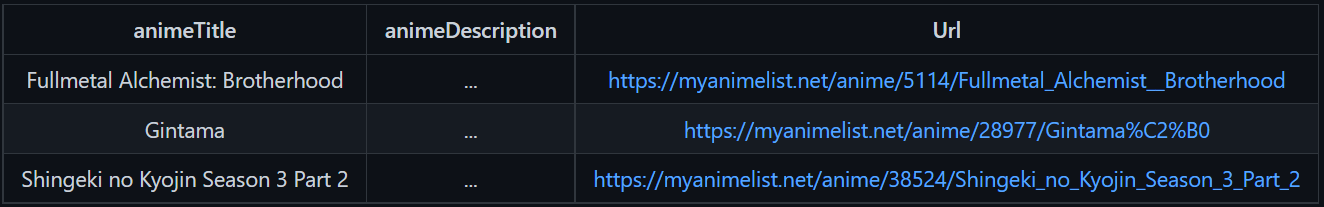

If everything works well in this step, we can go to the next point, and make your Search Engine more complex and better in answering queries.


In [ ]:
search()

search bar: saiyan race


,animeTitle,animeDescription,Url
1,Dragon Ball Z Special 1: Tatta Hitori no Saish...,"Bardock, Son Goku's father, is a low-ranking S...",https://myanimelist.net/anime/986/Dragon_Ball_...
2,Dragon Ball Kai,"Five years after the events of Dragon Ball, ma...",https://myanimelist.net/anime/6033/Dragon_Ball...
3,Dragon Ball Z,Five years after winning the World Martial Art...,https://myanimelist.net/anime/813/Dragon_Ball_Z\n
4,Dragon Ball Super: Broly,"Forty-one years ago on Planet Vegeta, home of ...",https://myanimelist.net/anime/36946/Dragon_Bal...


##2.2 Conjunctive query & Ranking score

For the second search engine, given a query, we want to get the top-k (the choice of k it's up to you!) documents related to the query. In particular:

- Find all the documents that contains all the words in the query.
- Sort them by their similarity with the query.
- Return in output k documents, or all the documents with non-zero similarity with the query when the results are less than k. we must use a heap data structure (we can use Python libraries) for maintaining the top-k documents.

To solve this task, we will have to use the *tfIdf* score, and the *Cosine similarity*. The field to consider it is still the synopsis. Let's see how.

###2.2.1 Inverted index

Our second Inverted Index is of this format:

{

term_id_1:[(document1, tfIdf_{term,document1}), (document2, tfIdf_{term,document2}), (document4, tfIdf_{term,document4}), ...],

term_id_2:[(document1, tfIdf_{term,document1}), (document3, tfIdf_{term,document3}), (document5, tfIdf_{term,document5}), (document6, tfIdf_{term,document6}), ...],

...}

Practically, for each word we want the list of documents in which it is contained in, and the relative *tfIdf* score.

**Tip**: *tfIdf* values are invariant with respect to the query, for this reason we can precalculate and store them accordingly.


In [ ]:
id, syn = [], []
for key in tqdm(D):
    id.append(key)
    a, b = text_preprocessing(D[key]['animeSynopsis'], lower = True, numbers = True, stemming = True)
    syn.append(b)

synopsis = {k:v for k,v in zip(id, syn)}

100%|██████████| 19125/19125 [00:30<00:00, 626.45it/s]


In [ ]:
tok = list(vocab.keys())
tok = np.array(tok)

for j in tqdm(range(0, len(tok))):
    term_j,  k = tok[j], 0

    for i in inv_index[term_j]:
        try:
            doc_i = synopsis[i]
            tfidf = ( doc_i.count(term_j) / len(doc_i) ) * ( np.log10( len(synopsis) / len(inv_index[term_j]) ))
            inv_index[term_j][k]  = (i, tfidf)
            k += 1
        except KeyError: pass
        continue

100%|██████████| 43615/43615 [00:04<00:00, 10526.90it/s]


In [ ]:
save_pickle(inv_index, "/content/drive/MyDrive/ADM-HW3/tfidf_D.pickle")
save_json(inv_index, "/content/drive/MyDrive/ADM-HW3/tfidf_D.json")

###2.2.2 Execute the query

In this new setting, given a query we get the right set of documents (i.e., those containing all the words in the query) and sort them according to their similairty to the query. For this purpose, as scoring function we will use the Cosine Similarity with respect to the tfIdf representations of the documents.

Given a query, that we let the user enter:

*saiyan race*

the search engine is supposed to return a list of documents, **ranked** by their Cosine Similarity with respect to the query entered in input.

More precisely, the output must contain:

- animeTitle
- animeDescription
- Url
- The similarity score of the documents with respect to the query (float value between 0 and 1)

**Example Output:**

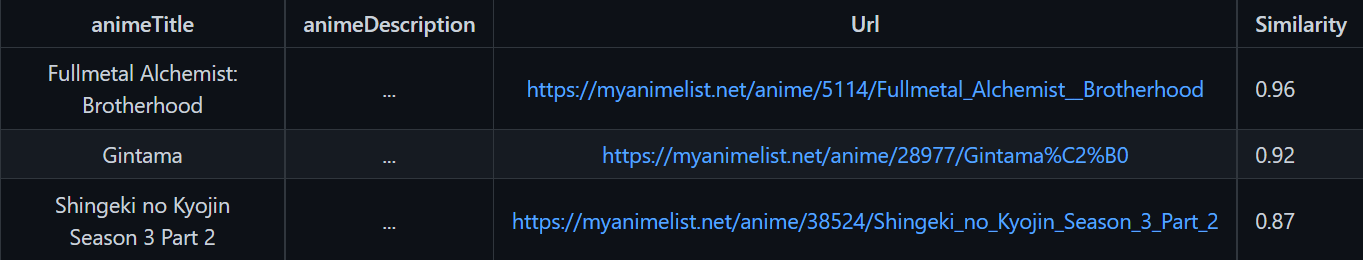

In [ ]:
search_cosine()

search bar: saiyan race


,animeTitle,animeDescription,Url,Similarity
1,Dragon Ball Z Special 1: Tatta Hitori no Saish...,"Bardock, Son Goku's father, is a low-ranking S...",https://myanimelist.net/anime/986/Dragon_Ball_...,0.58
2,Dragon Ball Z,Five years after winning the World Martial Art...,https://myanimelist.net/anime/813/Dragon_Ball_Z\n,0.05
3,Dragon Ball Super: Broly,"Forty-one years ago on Planet Vegeta, home of ...",https://myanimelist.net/anime/36946/Dragon_Bal...,0.05


#3. Define a new score!

This is a new metric to rank animes based on the queries of their users.

In this scenario, a single user can give in input more information than the single textual query, so we need to take into account all this information, and think a creative and logical way on how to answer at user's requests.

Practically:

1. The user will enter we a text query. As a starting point, get the query-related documents by exploiting the search engine of Step 2.1.

2. Once we have the documents, we need to sort them according to your new score. In this step we won't have anymore to take into account just the plot of the documents, we must use the remaining variables in your dataset (or new possible variables that we can create from the existing ones...). we must use a heap data structure (we can use Python libraries) for maintaining the top-k documents.

**Q**: How to sort them? 

**A**: Allow the user to specify more information, that we find in the documents, and define a new metric that ranks the results based on the new request. we can also use other information regarding the anime to score some animes above others.


## Our score formula
We decided to assign a doubble score for the maching of the title and the tokens inside the query.
Exactly, for each anime, the score of matching ($Score_{Title}$) is figured by the ration of number of tokens inside the query and the title divided by the total number of token inside the query.
And we add the possibility to specify what kind of anime the user is looking for. 
If an anime supply the request the score rest the same, instead if the type is different the score will be multiplied by 0.7 .
The score of Popularity (the new one)is obtained by the product of the reciprocal of Popularity of an anime, times the number of members that it has, evrithing relativized.

$Score_{Title}=\frac{|Query ∩ Title|}{|Query|}$

$Score_{Synopsis}=cosinsimilarity(synopsis,query)$

$Score_{PopularityNew}= \frac{\frac{1}{Popularity}  NumberMembers }{Max(Score_{PopularityNew})}$

$I_{Type}=\left\{\begin{matrix}
 1 \quad\quad& if \quad Type_{Query} = Type_{Anime} \\ 
 0.7\quad\quad& if \quad Type_{Query} \neq Type_{Anime}
\end{matrix}\right.$



$NewScore=(2*Score_{Title}+  Score_{Synopsis}+ Score_{PopularityNew}) * I_{Type}$


In [ ]:
rank, members, popularity = [], [], []
score = {}
for key in tqdm(D):
    try:
        rank.append(int(D[key]['animeRank']))
        members.append(int(D[key]['animeMembers']))
        popularity.append(int(D[key]['animePopularity']))

        # we first found all the scores, once we had the max score we relativized the scores dividing by the max
        score[key] = ((1/(int(D[key]['animeRank']))) * int(D[key]['animeMembers']) * (1/(int(D[key]['animePopularity']))))/(891882.3333333333) 

    except ValueError: 
        rank.append(int(key[6:]))
        members.append(int(D[key]['animeMembers']))
        popularity.append(int(D[key]['animePopularity']))
        score[key] =  ((1/int(key[6:])) * int(D[key]['animeMembers']) * (1/(int(D[key]['animePopularity'])))/(891882.3333333333))
    continue

100%|██████████| 19125/19125 [00:00<00:00, 284601.47it/s]


In [ ]:
duck_duck_anime()

search bar: saiyan race

Do you want to add more information? [y/n]: y

PRESS ENTER TO SKIP A FIELD

type of the anime: tv

desired popularity of the anime from 0 (dont care at all) to 10 (only the most popular): 8


,animeTitle,animeDescription,Url,Score
1,Dragon Ball Z Special 1: Tatta Hitori no Saish...,"Bardock, Son Goku's father, is a low-ranking S...",https://myanimelist.net/anime/986/Dragon_Ball_...,0.406000
2,Dragon Ball Z,Five years after winning the World Martial Art...,https://myanimelist.net/anime/813/Dragon_Ball_Z\n,0.050033
3,Dragon Ball Kai,"Five years after the events of Dragon Ball, ma...",https://myanimelist.net/anime/6033/Dragon_Ball...,0.040001
4,Dragon Ball Super: Broly,"Forty-one years ago on Planet Vegeta, home of ...",https://myanimelist.net/anime/36946/Dragon_Bal...,0.035001


#4. BONUS: Understanding the anime's reviews

For the bonus question, we will be performing a simple sentiment analysis on the anime website. To do the latter, we will need the following instructions:

- we need to extract one additional feature taken from the Reviews section. It will be composed of the 3 first lines of each review (approximately 500 characters). Besides, we should take into account only the first 5 reviews for each anime. For example, for "Fullmetal Alchemist: Brotherhood", we are expected to retrieve the information highlighted in the next figure:

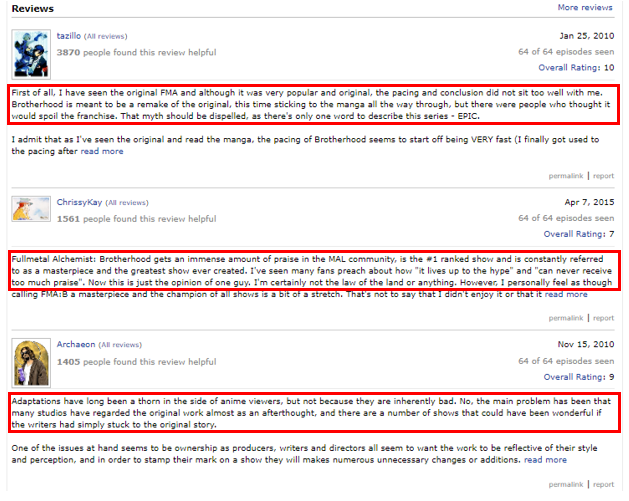

- Given the previous string of words, execute a sentiment analysis on them. Explain how we performed this analysis in detail, including any preprocessing, the type of model/models used, etc. (please bear in mind that we can use pre-trained models for this task).
- Report the results of your sentiment analysis, for example:

- What Anime Type are the most popular based on your analysis?
    - Does the number of episodes has any impact on the sentiment of the users?
    - Is your sentiment analysis in line with the scores of the animes? Explain your conclusions.
    - Any further analysis of your choice.

--------------------------------------------------------------------------------
Sentiment  analysis is  the  discipline  that   studies  people’s  opinions, outlooks, and  emotions  with regards to  products,  services,  companies,  
individuals,  etc. 

Our goal for this task is to analyze the sentiment of animes' viewer through their reviews in order to gain insight on their ratings. In so doing, we keep in mind that the satisfaction of viewers is one of the factors that most influences the success of movies and other entertainment initiatives.

As for the previous tasks, first of all we download the html pages containing the reviews and store them.

In [ ]:
# get urls of each anime's review page
anime_reviews = list(map(lambda ls: ls+"/reviews", anime)) 
with open('anime_reviews_urls.txt', 'w') as f:
   #looping over each element
   for element in anime_reviews:
        #writing to file line by line
        f.write('%s\n' % element)


# create folders to save the htmls pages
!mkdir "/content/drive/MyDrive/ADM-HW3/page_folders_reviews/"
for page in tqdm(range(1, 384)):
    folder = "page"+str(page)
    path = "/content/drive/MyDrive/ADM-HW3/page_folders_reviews/"+folder
    os.mkdir(path)

# download the html pages
for page in tqdm(range(0,383)):  
  folder = "/content/drive/MyDrive/ADM-HW3/page_folders_reviews/page"+str(page+1)
  update_page = 50*page
  for i in range(0,50): 
      url = f'{anime_reviews[update_page+i]}'
      response = requests.get(url)   
      filename = r""+folder+"/anime_rev"+str(update_page+i+1)+".html"
      with open(filename,'w', encoding='utf-8') as f:
          f.write(response.text)
      time.sleep(3)

In [ ]:
# Read filenames from all subdirectories recursively
files_list = [i for i in glob.glob('/content/drive/MyDrive/ADM-HW3/page_folders_reviews/**/*.html', recursive=True)]

Then, we parse the needed information using the Beautiful Soup library. 

In particular, for each anime, we save in a dictionary its **title**, the **first three lines of the first five reviews** and the **rating** given by each reviewer.

In [ ]:
# Parse needed content: name of the anime, first three lines of the first five reviews, rating

review_dict = {'name':[], 'rating':[], 'review':[]}

for el in files_list:
  with open(el, 'r') as f:
    soup = BeautifulSoup(f)

    reviews = soup.find_all('div', class_='spaceit textReadability word-break pt8 mt8')[:5]
    
    for review in reviews: 
      review_dict['name'].append(animeTitle(el))
      r = ' '.join(review.text.replace('\n', ' ').strip().split()[12:]) # skip not needed information
      three_lines = r[:500] + r[500:][:r[500:].find(".")] # get until first dot after 500 characters
      review_dict['review'].append(three_lines)
      review_dict['rating'].append(review.text[11:14].replace('\n', ' ').strip())
         

In [ ]:
# create dataframe with needed information
df_reviews = pd.DataFrame(review_dict) 

In [ ]:
# Save dataframe for future uses

df_reviews.to_excel('df_reviews1.xlsx', index=False) 
files.download("df_reviews1.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_rev = pd.read_excel("/content/drive/MyDrive/ADM-HW3/df_reviews.xlsx")

We proceed our analysis visualizing the data through dataframes.

In [ ]:
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 50)
df_rev.head(5)

,name,rating,review
0,Fullmetal Alchemist: Brotherhood,10,"First of all, I have seen the original FMA and although it was very popular and original, the pacing and conclusion did not sit too well with me. Brotherhood is meant to be a remake of the original, this time sticking to the manga all the way through, but there were people who thought it would spoil the franchise. That myth should be dispelled, as there's only one word to describe this series - EPIC. I admit that as I've seen the original and read the manga, the pacing of Brotherhood seems to start off being VERY fast (I finally got used to the pacing after watching the first fifteen eps or so)"
1,Fullmetal Alchemist: Brotherhood,7,"Fullmetal Alchemist: Brotherhood gets an immense amount of praise in the MAL community, is the #1 ranked show and is constantly referred to as a masterpiece and the greatest show ever created. I've seen many fans preach about how ""it lives up to the hype"" and ""can never receive too much praise"". Now this is just the opinion of one guy. I'm certainly not the law of the land or anything. However, I personally feel as though calling FMA:B a masterpiece and the champion of all shows is a bit of a stretch"
2,Fullmetal Alchemist: Brotherhood,9,"Adaptations have long been a thorn in the side of anime viewers, but not because they are inherently bad. No, the main problem has been that many studios have regarded the original work almost as an afterthought, and there are a number of shows that could have been wonderful if the writers had simply stuck to the original story. One of the issues at hand seems to be ownership as producers, writers and directors all seem to want the work to be reflective of their style and perception, and in order to stamp their mark on a show they will makes numerous unnecessary changes or additions"
3,Fullmetal Alchemist: Brotherhood,7,"Overview: FMA Brotherhood is an anime that needs no introduction. This is the highest rated anime on all of MAL. This is the anime that the current generation of anime fans holds above all others as the greatest single anime EVER made! In the following paragraphs, I will be reviewing this legendary series and discussing whether or not it truly deserves this title. SPOILERS for both Brotherhood and 2003 FMA!!!! Plot: The plot takes place in the country of Armestris, which is basically like an alternate WW2 Germany"
4,Fullmetal Alchemist: Brotherhood,5,"Since I couldn't find any legitimate objective analysis in any of these fanboy reviews, I decided put my own review: Here's why FMA:B and it's Manga counterpart don't work: It's just a disjointed piece of art. The initial premise of the narrative: two young siblings that horrifically lose their mother and parts of themselves is incredibly dark and powerfully poignant. Their journey to find the philosophers stone is one that's objectively adventurous but the endpoint is still inherently adult and sophisticatedly gritty; especially as it delves into the implications of bringing a dead person back to life early on in the series"


We check for null values and duplicates. We have no missing values, but it seems that 28 reviews have been written twice. Upon further inspection, we discover that these reviews refer to different animes, so we decide to keep them in our dataset, as they only address the fact that some people having the same sentiment towards different animes used multiple times the same review, instead of writing separate ones.

In [ ]:
df_rev.isnull().sum()

name      0
rating    0
review    0
dtype: int64

In [ ]:
duplicateRowsDF = df_rev[df_rev.duplicated(['review'])]
print(len(duplicateRowsDF), "reviews have duplicates")

28 reviews have duplicates


In [ ]:
duplicateRowsDF = df_rev[df_rev.duplicated()] # no two lines are exactly the same
duplicateRowsDF

,name,rating,review


We append to the dataframe the columns referring to the **type** of anime, the **number of episodes** and the **score**. Also, we create a **sentiment** column by assigning a ***positive*** tag to reviews with a rating higher than 5 and a ***negative*** tag to reviews with a rating lower or equal to 5. This is particularly important as such column will work as our dependent variable in the modelling phase.

In [ ]:
# Read filenames from all subdirectories recursively
file_list = [i for i in glob.glob('/content/drive/MyDrive/ADM-HW3/tsv_files/**/*.tsv', recursive=True)]

#define columns names
cols = ['Title', 'Type', 'Numb_Episodes', 'ReleaseDate', 'EndDate', 'Numb_Members', 
                'Score', 'Users', 'Rank', 'Popularity', 'Synopsis', 'Related_Animes', 
                'Characters', 'Voices', 'Staff']

# create dataframe 
df = pd.concat([pd.read_csv(x, sep='\t', header=None, names = cols) for x in file_list], axis = 0)

In [ ]:
df_rev['type'] = df_rev.name.map(df.set_index('Title')['Type'].to_dict()) # add type column
df_rev['n_episodes'] = df_rev.name.map(df.set_index('Title')['Numb_Episodes'].to_dict()) # add column with number of episodes
df_rev['score'] = df_rev.name.map(df.set_index('Title')['Score'].to_dict()) # add score column 

df_rev["sentiment"] = np.where(df_rev["rating"] > 5, "Positive", "Negative") # add sentiment column

In [ ]:
df_rev.head(5)

,name,rating,review
0,Fullmetal Alchemist: Brotherhood,10,"First of all, I have seen the original FMA and..."
1,Fullmetal Alchemist: Brotherhood,7,Fullmetal Alchemist: Brotherhood gets an immen...
2,Fullmetal Alchemist: Brotherhood,9,Adaptations have long been a thorn in the side...
3,Fullmetal Alchemist: Brotherhood,7,Overview: FMA Brotherhood is an anime that nee...
4,Fullmetal Alchemist: Brotherhood,5,Since I couldn't find any legitimate objective...


Effectively pre-processing the text data that we are going to feed our model is a fundamental step to ensure the successful outcome of our analysis.

To get rid of the **noise** in our data, we convert all the reviews' texts to lowercase, remove punctuation and eliminate English stop words. In this way, our algorithm won't focus on words such as "*the*", "*a*", "*of*", etc., which have a high frequency, but no particular meaning. 

In [ ]:
#convert to lower case
df_rev["proc_review"] =  df_rev["review"].str.lower()

#remove punctuation
df_rev["proc_review"] = df_rev['proc_review'].str.replace('[{}]'.format(string.punctuation), '')
df_rev["proc_review"] =  df_rev["proc_review"].str.replace("’", "", regex=True)

# remove stop words
stop = stopwords.words('english')
df_rev["proc_review"] =  df_rev["proc_review"].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))

We move along with plotting some information. We find out that positive reviews outnumber negative ones and that there is not really much of a difference in the words appearing more frequently in positive and negative reviews, with the first ten ones being exactly the same. The Word Cloud, too, fails to provide us with interesting details.

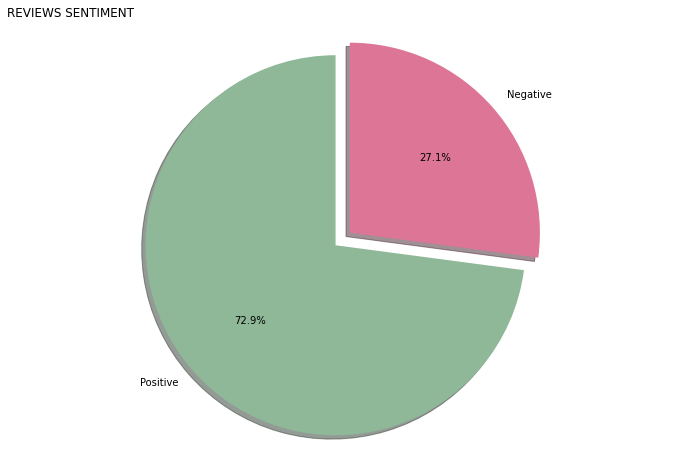

In [ ]:
labels = 'Positive', 'Negative'
sizes = [df_rev.sentiment.value_counts().sort_values()[1], df_rev.sentiment.value_counts().sort_values()[0]]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
colors = ['#8EB897', '#DD7596']

fig1 = plt.figure(figsize=(12,8))
plt.title('REVIEWS SENTIMENT', loc = 'left')
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = colors)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
df_rev.sentiment.value_counts().sort_values()[1]

22946

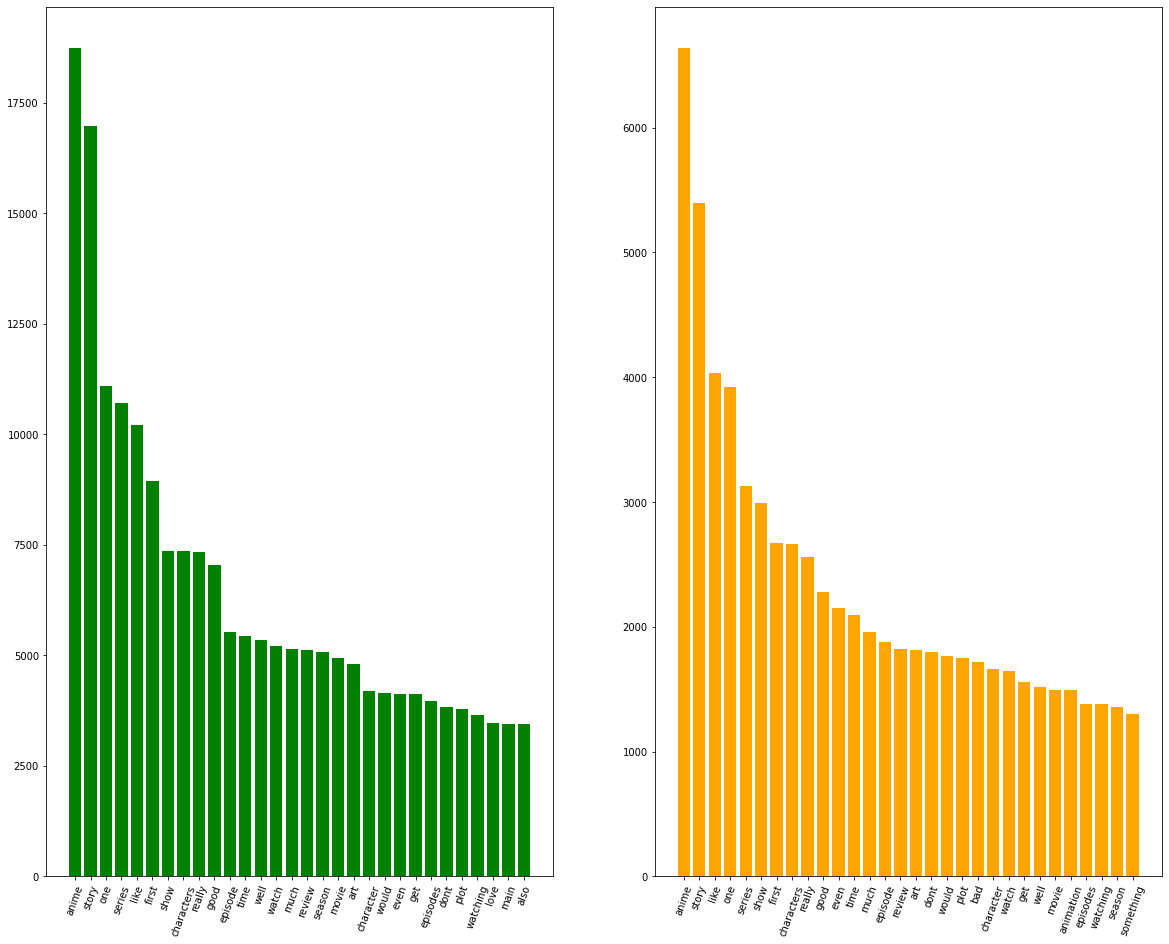

In [ ]:
review_pos = df_rev[df_rev["sentiment"] == "Positive"]
review_neg = df_rev[df_rev["sentiment"]=='Negative']

word_count1 = Counter(word_tokenize('\n'.join(review_pos["proc_review"])))
word_count2 = Counter(word_tokenize('\n'.join(review_neg["proc_review"])))

w1 = word_count1.most_common()[:30]
w2 = word_count2.most_common()[:30]

figure(num=None, figsize=(20, 16))

plt.subplot(1, 2, 1)
plt.bar(range(len(w1)), [x[1] for x in w1], align='center', color = "green")
plt.xticks(range(len(w1)), [x[0] for x in w1])
plt.xticks(rotation=70)


plt.subplot(1, 2, 2)
plt.bar(range(len(w2)), [x[1] for x in w2], align='center', color = "orange")
plt.xticks(range(len(w2)), [x[0] for x in w2])
plt.xticks(rotation=70)

plt.show()

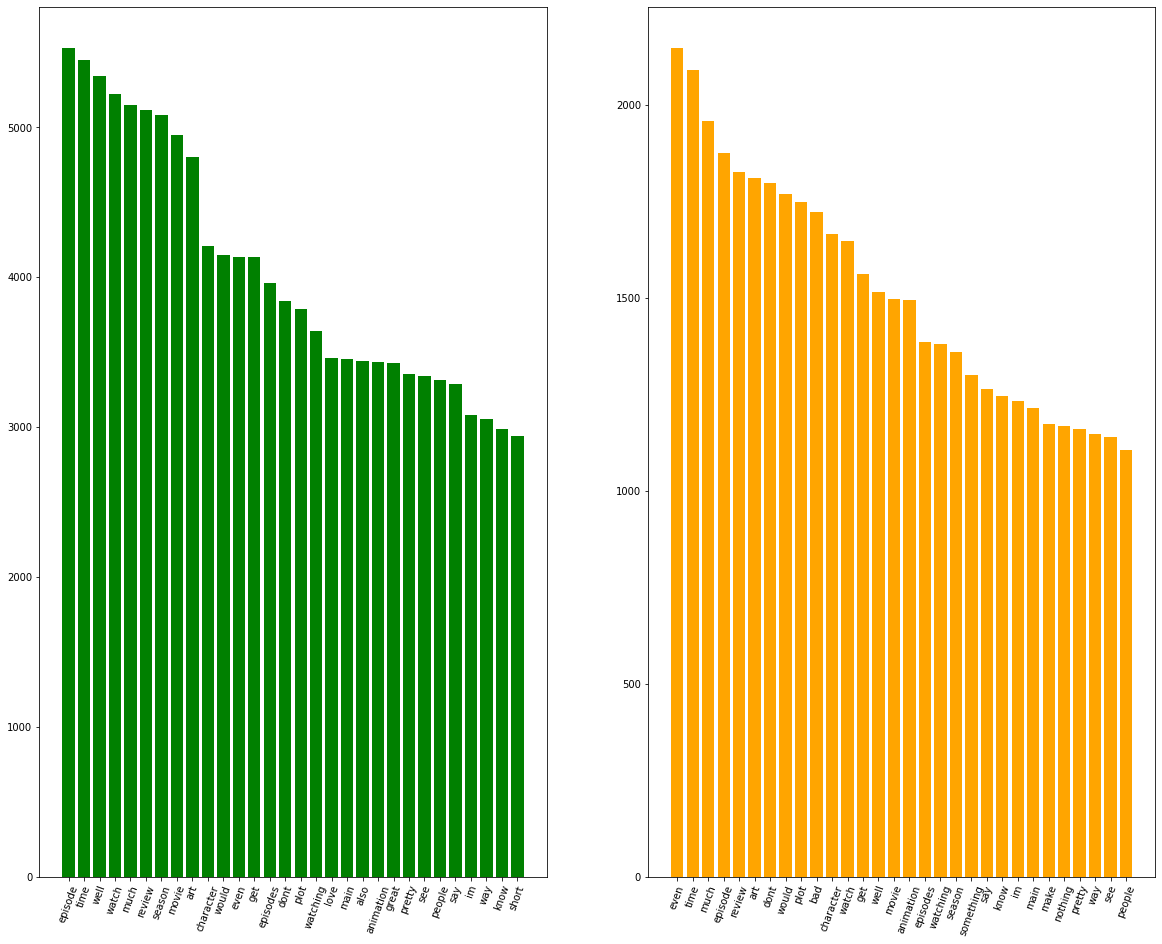

In [ ]:
# no noticeable difference in the frequency of words even after the first ten most common ones

w1 = word_count1.most_common()[10:40] # from the 10th to the 40th most common words
w2 = word_count2.most_common()[10:40]

figure(num=None, figsize=(20, 16))

plt.subplot(1, 2, 1)
plt.bar(range(len(w1)), [x[1] for x in w1], align='center', color = "green")
plt.xticks(range(len(w1)), [x[0] for x in w1])
plt.xticks(rotation=70)


plt.subplot(1, 2, 2)
plt.bar(range(len(w2)), [x[1] for x in w2], align='center', color = "orange")
plt.xticks(range(len(w2)), [x[0] for x in w2])
plt.xticks(rotation=70)

plt.show()

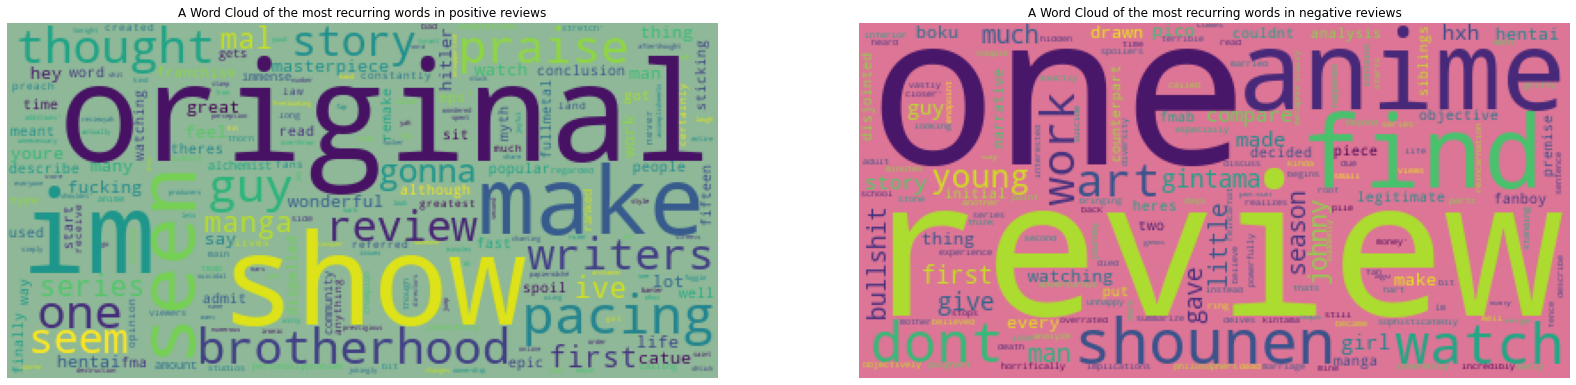

In [ ]:
text1 = review_pos['proc_review'].values 
text2 = review_neg['proc_review'].values 

figure(num=None, figsize=(28, 26))

plt.subplot(1, 2, 1)
wordcloud = WordCloud(background_color='#8EB897').generate(str(text1))

plt.imshow(wordcloud)
plt.axis("off")
plt.title("A Word Cloud of the most recurring words in positive reviews")


plt.subplot(1, 2, 2)
wordcloud = WordCloud(background_color='#DD7596').generate(str(text2))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("A Word Cloud of the most recurring words in negative reviews")
plt.show()

**Time for modelling!** 

We implement two Logistic Regression models, using two different vectorizers: **CountVectorizer** and **TfidfVectorizer**, both provided by Python’s Scikit-Learn library.

The first one counts the number of times each word appears in the corpus, thus favouring more frequent words and penalizing rarer ones (which - instead - could help in supplying us with useful information).

For this reason, the TfidfVectorizer is often preferred, as it not only concentrates on the frequency of words present in the document, but also weighs the word counts by how frequent they are, rewarding less common words. 

In [ ]:
X = df_rev["proc_review"]
y = df_rev["sentiment"]


X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3, random_state = 225)

vectorizer = CountVectorizer()
classifier = LogisticRegression(solver = "lbfgs", max_iter=1000)
model = Pipeline([('vectorizer', vectorizer),('classifier', classifier)])
model.fit(X_train, Y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

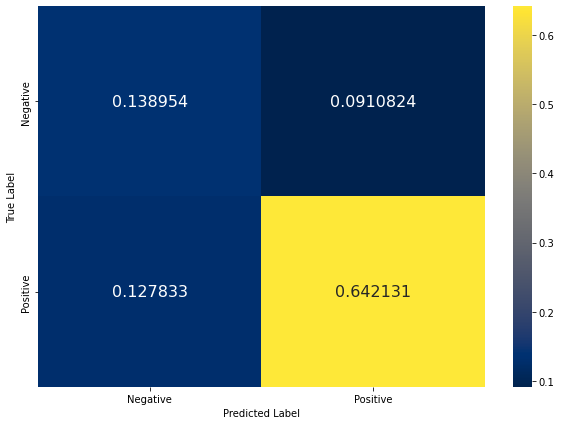

In [ ]:
cm = confusion_matrix(test_preds, Y_test, normalize='all')

plt.figure(figsize=(10,7))
ax = sns.heatmap(cm, annot=True, fmt='g',  annot_kws={"size": 16}, cmap="cividis")

ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label');

ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])

plt.show()

In [ ]:
acc_train = accuracy_score(Y_train, train_preds)
acc_test =  accuracy_score(Y_test, test_preds)

print("Train accuracy: ", acc_train)
print("Test accuracy: ", acc_test)

Train accuracy:  0.8390449820707185
Test accuracy:  0.7941114170726541


The **accuracy** on the test set with the Count Vectorizer is **78%**, with very bad overfitting. Let's see if we can do better with the TF-IDF method.

In [ ]:
X = df_rev["proc_review"]
y = df_rev["sentiment"]

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3, random_state = 225)

vectorizer = TfidfVectorizer()
classifier = LogisticRegression(solver = "lbfgs")
model = Pipeline([('vectorizer', vectorizer),('classifier', classifier)])
model.fit(X_train, Y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

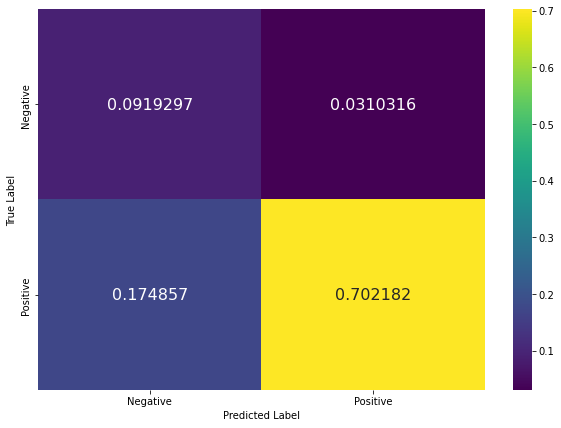

In [ ]:
cm = confusion_matrix(test_preds, Y_test, normalize='all')

plt.figure(figsize=(10,7))
ax = sns.heatmap(cm, annot=True, fmt='g',  annot_kws={"size": 16}, cmap="viridis")

ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label');

ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])

plt.show()

In [ ]:
acc_train = accuracy_score(Y_train, train_preds)
acc_test =  accuracy_score(Y_test, test_preds)

print("Train accuracy: ", acc_train)
print("Test accuracy: ", acc_test)

Train accuracy:  0.8390449820707185
Test accuracy:  0.7941114170726541


It turns out that, under equal conditions (same data and same model), the TF-IDF vectorizer actually does perform better, reaching a higher accuracy on the test set (**79%**) and overfitting much less. 

We can consider these results satisfactory, given the nature of the data we provided (e.g., wrong labels, ironic phrases, the presence of Japanese words, the fact that we only focused on the first three lines of each review, etc.)

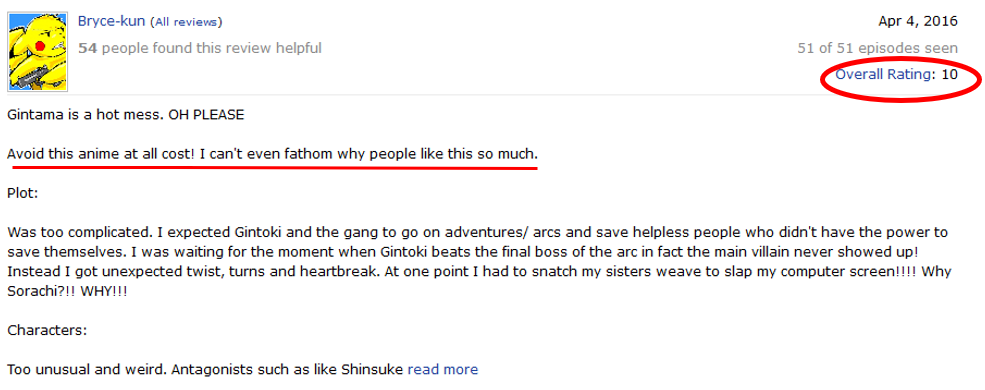

We try out new opinions:

In [ ]:
new_review = [input("Insert your review: ")]
result = model.predict(new_review)

print(colored(result[0], 'red', attrs=['bold']))

Insert your review: i like it
Positive


and we have a look to the reviews whose sentiment we wrongly predicted.

In [ ]:
ind_list = X_test.index.values.tolist()
df_test = df_rev.iloc[ind_list]
df_test = df_test.assign(preds=preds)

wrong_preds = df_test.query('sentiment != preds')
wrong_preds.head(5)

,name,rating,review,proc_review,type,n_episodes,score,sentiment,preds
25413,Hoshi no Umi no Amuri,5,"Hoshi no Umi no Amuri is a Studio Hibari original from 2008. We remember them for their work on the horrendous Kashimashi and the mediocre Venus Versus Virus. So, great sign there. Let's delve into it and hope for the best. Story: We open with a group of girls travelling through space when their shuttle is attacked and they find themselves floating in space. That is until they're dragged away by strange beings for nefarious purposes and have a super sentai style group sent to rescue them. Fortunately, they find floating capsules with special transformation suits that can draw out their powers",hoshi umi amuri studio hibari original 2008 remember work horrendous kashimashi mediocre venus versus virus great sign lets delve hope best story open group girls travelling space shuttle attacked find floating space theyre dragged away strange beings nefarious purposes super sentai style group sent rescue fortunately find floating capsules special transformation suits draw powers,OVA,3.0,5.75,Negative,Positive
27922,Tekkon Kinkreet Pilot,1,"What is this? The sound hurt my ears, honestly. It's so bad. It doesn't resemble any form of enjoyable music. It's just the type of trash you see in those really cheap 3D baby CGI shows on Nickelodeon. The story doesn't exist, really. 3D baby CGI shows on Nickelodeon. The character? No. 3D baby CGI shows on Nickelodeon. What's enjoyment? 3D baby CGI shows on Nickelodeon. Sure, you might criticize me for picking on an innocent little 3D project, but screw this. I hate stuff like this. It's useless and annoying",sound hurt ears honestly bad doesnt resemble form enjoyable music type trash see really cheap 3d baby cgi shows nickelodeon story doesnt exist really 3d baby cgi shows nickelodeon character 3d baby cgi shows nickelodeon whats enjoyment 3d baby cgi shows nickelodeon sure might criticize picking innocent little 3d project screw hate stuff like useless annoying,Special,1.0,4.64,Negative,Positive
30544,Anata wa Watashi no Mono,6,Tags: Femdom Humiliation NTR Rape Double-Penetration This hentai started off with strong Femdom feel to it. The Girl dominates the guy completely. But by episode 2 it turns somwhat into NTR. Personally I like NTR. But the people who liked it because of its Femdom aspect would be disappointed in the 2nd episode. ***Spoilers ahead**** Basically the girl arranges a meet up with 2 random guys. Orders the boyfriend to not move whatever happens. And then proceeds to suck off those random guys in front of the boyfriend,tags femdom humiliation ntr rape doublepenetration hentai started strong femdom feel girl dominates guy completely episode 2 turns somwhat ntr personally like ntr people liked femdom aspect would disappointed 2nd episode spoilers ahead basically girl arranges meet 2 random guys orders boyfriend move whatever happens proceeds suck random guys front boyfriend,OVA,2.0,NaN,Positive,Negative
6213,Sakamoto Desu ga?,10,"“Who.. are you?” “Haven’t you heard? I’m Sakamoto.” You’d almost wish it started out like this, there’s that perpetual gnawing going on in the obscured depths of your conscience that bugs you for some normality, some profound simplicity in going about an anime you might never have even heard of. This auxiliary introduction to this mysterious, clean-looking man, unfortunately, doesn’t exist. Why, of course, would there be such a need? One does not introduce Sakamoto. One does not simply require the induction of any mainstream preface to unveil such a magnificent being",“who you” “havent heard im sakamoto” youd almost wish started like theres perpetual gnawing going obscured depths conscience bugs normality profound simplicity going anime might never even heard auxiliary introduction mysterious cleanlooking man unfortunately doesnt exist course would need one introduce sakamoto one simply require induction mainstream preface unveil magnificent,TV,12.0,7.57,Pos

If we analyze, for example, the last review printed in the prevoius chunk of code, we see that the wrong label predicted by the algorithm is due to the fact that the lines we focused on contain positive words, while the real negative opinion is expressed only further down.


We should take these instances into consideration when interpreting the results we obtained. 


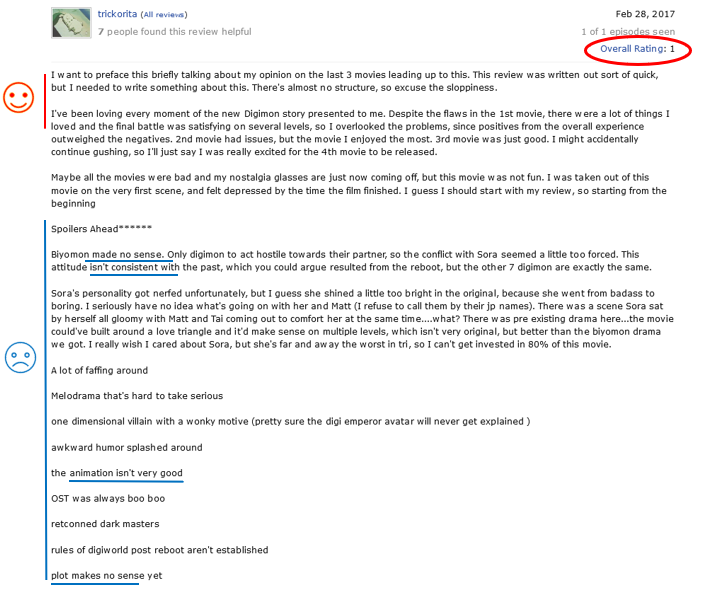

As requested, we now perform a few further analyses taking into account the type of animes reviewed, the  number of episodes broadcasted and the general score received by each anime.


In [ ]:
df_test.groupby(['type', 'preds']).size()
grouped_df = df_test.groupby(['type', 'preds'])
grouped_df = pd.DataFrame(grouped_df.size().reset_index(name = "Count"))

grouped_df['%'] = 100 * grouped_df['Count'] / grouped_df.groupby('type')['Count'].transform('sum')
grouped_df.sort_values(by="%", ascending = False)

# cap count from 15 above
grouped_df1 = grouped_df[grouped_df['Count'] > 15]
grouped_df1.sort_values(by="%", ascending = False)

,type,preds,Count,%
4,Movie,Positive,1300,88.797814
12,TV,Positive,3858,88.405133
10,Special,Positive,652,88.346883
8,OVA,Positive,1790,86.977648
1,Edit,Positive,130,83.333333
6,ONA,Positive,533,83.151326
5,ONA,Negative,108,16.848674
0,Edit,Negative,26,16.666667
7,OVA,Negative,268,13.022352
9,Special,Negative,86,11.653117


In [ ]:
df_test.groupby(['n_episodes', 'preds']).size()
grouped_df = df_test.groupby(['n_episodes', 'preds'])
grouped_df = pd.DataFrame(grouped_df.size().reset_index(name = "Count"))
grouped_df['Percentage'] = 100 * grouped_df['Count'] / grouped_df.groupby('n_episodes')['Count'].transform('sum')
grouped_df.sort_values(by="Percentage", ascending = False)

,n_episodes,preds,Count,Percentage
185,1787.0,Positive,1,100.000000
60,34.0,Positive,3,100.000000
101,63.0,Positive,3,100.000000
100,62.0,Positive,2,100.000000
99,61.0,Positive,1,100.000000
...,...,...,...,...
36,20.0,Negative,2,6.250000
47,26.0,Negative,28,6.236080
82,49.0,Negative,2,5.000000
30,16.0,Negative,1,3.571429


In [ ]:
# cap count from 15 above
grouped_df = grouped_df[grouped_df['Count'] > 15]
grouped_df.sort_values(by="Percentage", ascending = False)

,n_episodes,preds,Count,Percentage
79,47.0,Positive,17,100.000000
85,50.0,Positive,54,98.181818
31,16.0,Positive,27,96.428571
83,49.0,Positive,38,95.000000
48,26.0,Positive,421,93.763920
37,20.0,Positive,30,93.750000
42,23.0,Positive,29,93.548387
66,39.0,Positive,43,93.478261
13,7.0,Positive,53,92.982456
44,24.0,Positive,260,92.198582


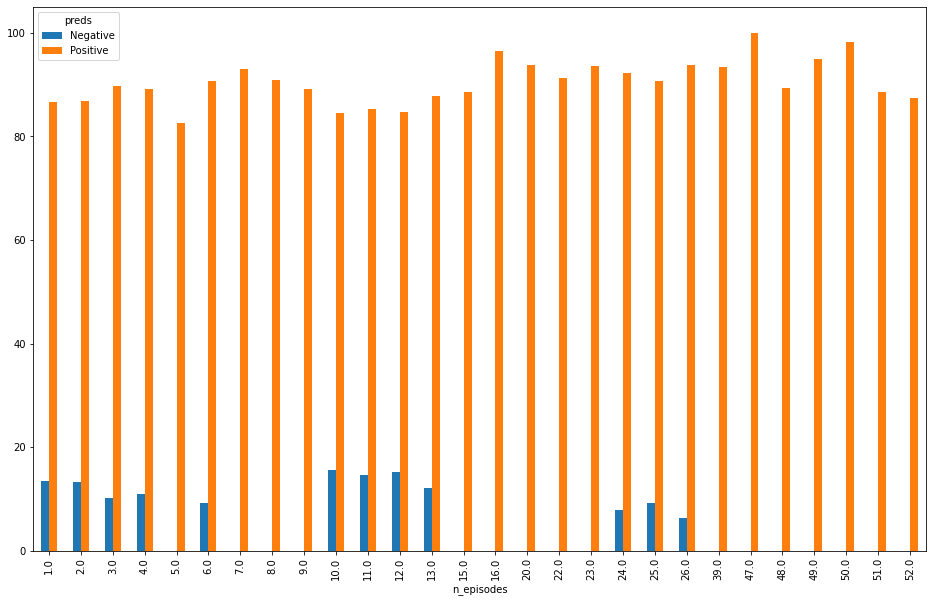

In [ ]:
grouped_df.set_index(['n_episodes','preds'])['Percentage'].unstack().plot.bar()
plt.show()

In [ ]:
# create new variable mapping animes with score larger or equal to 6 to a "High Score" tag
# and animes with score lower than 6 to a "Low Score" tag
df_test["score_category"] = np.where(df_test["score"] >= 6, "High Score", "Low Score") 

df_test.groupby(['score_category', 'preds']).size()
grouped_df = df_test.groupby(['score_category', 'preds'])
grouped_df = pd.DataFrame(grouped_df.size().reset_index(name = "Count"))

grouped_df['%'] = 100 * grouped_df['Count'] / grouped_df.groupby('score_category')['Count'].transform('sum')
grouped_df.sort_values(by="%", ascending = False)

,score_category,preds,Count,%
1,High Score,Positive,6559,90.593923
3,Low Score,Positive,1722,78.201635
2,Low Score,Negative,480,21.798365
0,High Score,Negative,681,9.406077


In [ ]:
# see with actual sentiment (not predictions)
df_test["score_category"] = np.where(df_test["score"] >= 6, "High Score", "Low Score") 

df_test.groupby(['score_category', 'sentiment']).size()
grouped_df = df_test.groupby(['score_category', 'sentiment'])
grouped_df = pd.DataFrame(grouped_df.size().reset_index(name = "Count"))

grouped_df['%'] = 100 * grouped_df['Count'] / grouped_df.groupby('score_category')['Count'].transform('sum')
grouped_df.sort_values(by="%", ascending = False)

,score_category,sentiment,Count,%
1,High Score,Positive,5677,78.411602
3,Low Score,Positive,1246,56.584923
2,Low Score,Negative,956,43.415077
0,High Score,Negative,1563,21.588398


Based on our analysis, it turns out that the most popular Anime Type are **Movies**, that obtain 88% positive votes, followed by **TV** and **Specials** (both receiving 88% positive votes, too). 

The number of episodes does not seem to have an impact on the percentage of positive (and negative) reviews received, as can be visually deduced by looking at the orange and blue barplot above, which shows little difference between categories.

Lastly, it seems that our analysis is not fully in line with the overall rating of the animes, especially with respect to low rated animes, which are predicted as receiving mostly positive feedbacks. Still, if we look at the actual sentiment of the users whose reviews we examined, we find ourselves in front of a similar situation. It may look like we either crawled positive reviews for unsuccessful animes or our model does a poor job at identifying negative reviews (which is not true, as showed by the confusion matrix above). 

It turns out that it may all make sense, as the score assigned by the MyAnimeList website does not consider the rating of the reviews. (See https://myanimelist.net/info.php?go=topanime)

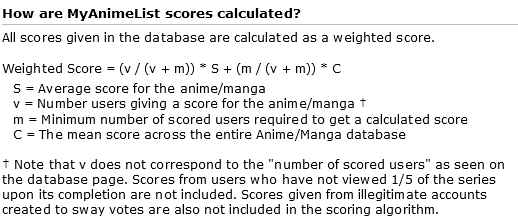


#5. Algorithmic question

we consult for a personal trainer who has a back-to-back sequence of requests for appointments. A sequence of requests is of the form > 30, 40, 25, 50, 30, 20 where each number is the time that the person who makes the appointment wants to spend. we need to accept some requests, however we need a break between them, so we cannot accept two consecutive requests. For example, **[30, 50, 20]** is an acceptable solution (of duration 100), but **[30, 40, 50, 20]** is not, because 30 and 40 are two consecutive appointments. Your goal is to provide to the personal trainer a schedule that maximizes the total length of the accepted appointments. For example, in the previous instance, the optimal solution is **[40, 50, 20]**, of total duration *110*.

1. Write an algorithm that computes the acceptable solution with the longest possible duration.
2. Implement a program that given in input an instance in the form given above, gives the optimal solution.

In [ ]:
# 1. pseudocode

```
schedule(list):

zeros = [zeros array of length(list) + 2]
final_solution = [ ]
flag = True # a boolean condition to get back the selected elements 

for i in 2 : length(list) + 2:
    
    zeros[i] = max(previous value in zeros, previous - 1 + current value of l in index i-2)
    reverse list
    reverse zeros

for i in 0 : length(zeros) - 2: # now we have the zeros on the last two values

       first condition to check if two consecutive elements of the zeros list are different and if they are and the flag is true:

                        add to the final solution the first of the two
                        set flag to false to avoid the following element

       second condition to check whether or not avoid the following element and in case:         
        
                        set flag back to true

       third condition to check if the elements are the same, in case:            
       
                        set flag to True so in the next loop if elements are different we add to final solution the value with the biggest 
                        index between the ones that have the same value 

return reversed final_solution


In [ ]:
# 2. implementation

def algolist(l):
    zeros = [0] * (len(l)+2)
    finale=[]
    flag=True

    for i in range(2,len(l)+2):
        zeros[i]=max(zeros[i-2]+l[i-2],zeros[i-1])

    l.reverse()
    zeros.reverse()

    for i in range(len(zeros)-2):
        if zeros[i]!=zeros[i+1] and flag:
          finale.append(l[i])
          flag=False

        elif zeros[i]!=zeros[i+1] and flag==False:
          flag=True

        elif zeros[i]==zeros[i+1] and flag==False:
          flag=True

    finale.reverse()

    return finale

In [ ]:
l = [120, 200, 180, 150, 250, 160, 160]
algolist(l)

[120, 180, 250, 160]